In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import util

# Data Imputation

## Outline
* Review: How are data missing?
* Single Valued Imputation
* Probabilistic Imputation (drawing from the distribution)

### Review: Permutation Tests

* Given two observed groups of data, are they from different distributions?
* **Example**: Given a list of people's heights, are heights of the men vs. women significantly different?
* Permutation test assesses the likelihood the difference in average height of each gender is significantly different.

In [2]:
heights = pd.read_csv('./galton.csv')
heights = (
    heights
    .rename(columns={'childHeight': 'child', 'childNum': 'number'})
    .drop('midparentHeight', axis=1)
)
heights.head()

,family,father,mother,children,number,gender,child
0,1,78.5,67.0,4,1,male,73.2
1,1,78.5,67.0,4,2,female,69.2
2,1,78.5,67.0,4,3,female,69.0
3,1,78.5,67.0,4,4,female,69.0
4,2,75.5,66.5,4,1,male,73.5


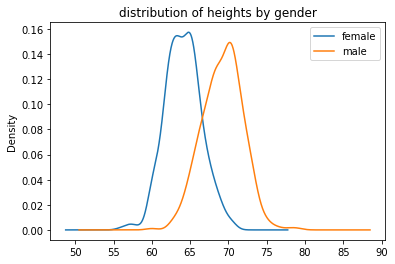

In [3]:
heights.groupby('gender').child.plot(kind='kde', legend=True, title='distribution of heights by gender');

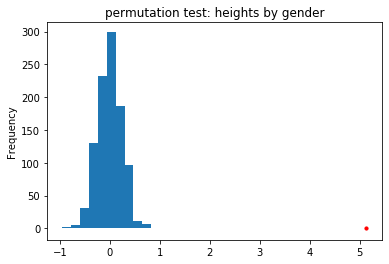

In [4]:
distr, obs = util.permutation_test(heights, 'child',  'gender', util.diff_in_means)

pd.Series(distr).plot(kind='hist', title='permutation test: heights by gender')
plt.scatter(obs, 0, color='r', s=10);

### Review: MCAR/MAR/NMAR

* **MCAR**: Data is *Missing Completely at Random* if there is no relationship between the missingness of the data and any values, observed or missing.

* **MAR**:  Data is *Missing at Random* if there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data. 

* **NMAR**: Data is *Not Missing at Random* if there is a relationship between the propensity of a value to be missing and its values. 

### Review: MCAR/MAR/NMAR  + think of examples

* **MCAR**: Data is *Missing Completely at Random* if 

* **MAR**:  Data is *Missing at Random* if 

* **NMAR**: Data is *Not Missing at Random* if 

### Example: Missingness of child height on father height (`MCAR`)

* To determine if the missingness of `child` height is dependent on height of `father`:
    - Check if the distribution of `father` heights looks the same when `child` is null vs. not-null.
    - Use a permutation test to check this!
* To assert that `child` is likely MCAR (unconditionally ignorable), the missingness of `child` height should *not* be dependent on *any* other column.

In [5]:
# make an MCAR dataset
heights_mcar = util.make_mcar(heights, 'child', pct=0.5)
heights_mcar.isnull().mean()

family      0.0
father      0.0
mother      0.0
children    0.0
number      0.0
gender      0.0
child       0.5
dtype: float64

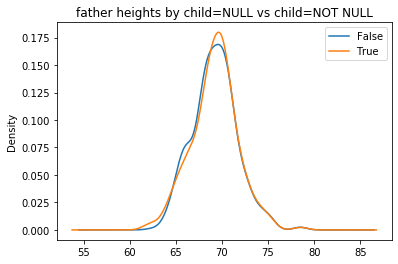

In [6]:
(
    heights_mcar
    .assign(is_null=heights_mcar.child.isnull())
    .groupby('is_null')
    .father
    .plot(kind='kde', legend=True, title='father heights by child=NULL vs child=NOT NULL')
);

In [7]:
# run a permutation test
# randomly shuffle missing/not missing
distr, obs = util.permutation_test(
    heights_mcar.assign(is_null=heights_mcar.child.isnull()), 
    'father',  'is_null', util.ks)

p-value: 0.850000


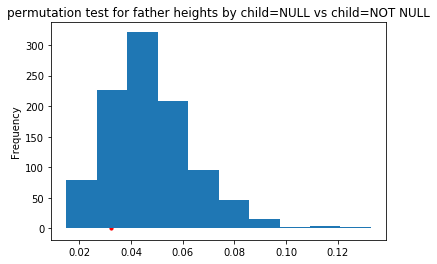

In [8]:
pval = (distr >= obs).mean()
print('p-value: %f' % pval)
pd.Series(distr).plot(kind='hist', title='permutation test for father heights by child=NULL vs child=NOT NULL')
plt.scatter(obs, 0, color='r', s=10);

### Example: Missingness of child height on father height (Conditionally Ignorable: `MAR`)

* To determine if the missingness of `child` height is dependent on height of `father`:
    - Check if the distribution of `father` heights looks the same when `child` is null vs. not-null.
    - Use a permutation test to check this!

In [9]:
# dependency of the missingness on child by father
# 75% of the data is missing
heights_mar = util.make_mar_on_num(heights, 'child', 'father', pct=0.75)
heights_mar.isnull().mean()

family      0.000000
father      0.000000
mother      0.000000
children    0.000000
number      0.000000
gender      0.000000
child       0.749465
dtype: float64

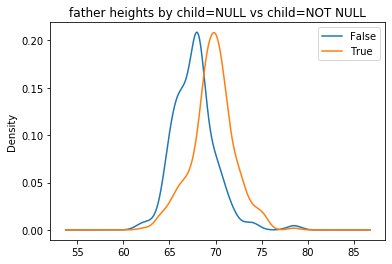

In [10]:
(
    heights_mar
    .assign(is_null=heights_mar.child.isnull())
    .groupby('is_null')
    .father
    .plot(kind='kde', legend=True, title='father heights by child=NULL vs child=NOT NULL')
);
# taller fathers are less likely to report the height if their child
# when child hight is missing, the mean father hight is higher

In [11]:
# if you want to predict a child height from father height
# taller fathers tend to have taller children 
# we will underestimate the height of the children in our predictions
# there is a pattern to the missing data: children height is missing more often 
# when fathers were tall

In [12]:
distr, obs = util.permutation_test(
    heights_mar.assign(is_null=heights_mar.child.isnull()), 
    'father',  'is_null', util.ks)

p-value: 0.000000


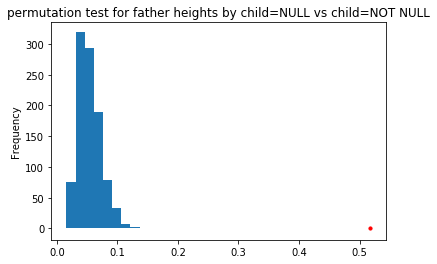

In [13]:
pval = (distr >= obs).mean()
print('p-value: %f' % pval)
pd.Series(distr).plot(kind='hist', title='permutation test for father heights by child=NULL vs child=NOT NULL')
plt.scatter(obs, 0, color='r', s=10);

# What to do with missing data?


## What to do with missing data?

* Given a dataset $Y$ with observed values $Y_{obs}$ and missing values $Y_{mis}$.
* $Y$ may appear quite different than $Y_{obs}$:
    - The mean and percentile may be different.
    - The variance may be different.
    - Correlations between variables may be different.

## Simple ways of dealing with missing data

If the data are ______, `.dropna()` doesn't significantly change the data. That is, it produces an unbiased estimate of the mean.

* MCAR (unconditionally ignorable / missing completely at random)

* MAR (conditionally ignorable / missing at random)

* NMAR (nonignorable / not missing at random)

* None of the above

## Ways of dealing with missing data: deletion

Using *listwise deletion* (dropping observations) to remove missing values:
* Results in unbiased means only when the data are *MCAR*. (rare)
* Removes observations with non-null data in other fields. (bad)
    - Improvement: can drop missing data only when computing with the column in question.
* Doesn't further bias the observed dataset.

Explain to yourself why these are true! (Recall DSC 10)

In [14]:
heights_mcar = util.make_mcar(heights, 'child', pct=0.60)
heights_mar = util.make_mar_on_num(heights, 'child', 'father', pct=0.60)

In [15]:
missings = pd.concat([
    heights.child.rename('complete'),
    heights_mcar.child.rename('mcar'),
    heights_mar.child.rename('mar')
], axis=1)

missings.head()

,complete,mcar,mar
0,73.2,73.2,NaN
1,69.2,NaN,NaN
2,69.0,NaN,NaN
3,69.0,69.0,NaN
4,73.5,NaN,NaN


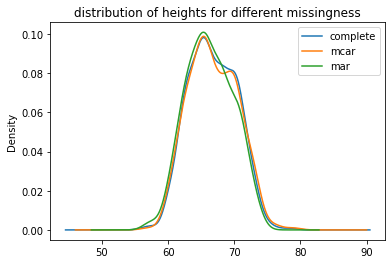

In [16]:
missings.plot(kind='kde', title='distribution of heights for different missingness');

In [17]:
missings.mean().rename('means').to_frame()

,means
complete,66.745931
mcar,66.801337
mar,66.265775


## Ways of dealing with missing data: imputation

Imputation is the act of filling in missing data with plausable values.

* Should be quick and easy to do
* Shouldn't "change" the dataset

These are hard to satisfy!

## Three kinds of imputation

* imputation with a single value: mean, median, mode
* imputation with a single value, using a model: regression, kNN
* (probabilistic) imputation by drawing from a distribution

Each has upsides and downsides; each works differently with different types of missingness.

## Mean imputation

* Imputing a missing value with the mean:
    - preserves the mean of the observed data
    - decreases the variance
    - biases the means across groups when not *MCAR*

## Mean imputation in the `heights` data
* Mean imputation of MCAR data
    - unbiased estimator of the mean.
    - decreases variance.

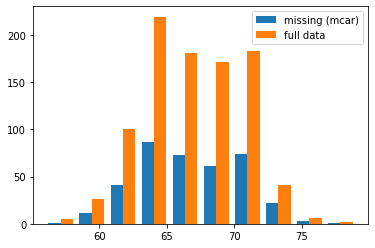

In [18]:
# counts of child heights
plt.hist([heights_mcar.child.dropna(), heights.child])
plt.legend(['missing (mcar)', 'full data']);

In [19]:
# impute with mean
heights_mcar_mfilled = heights_mcar.fillna(heights_mcar.child.mean())

In [20]:
print(
    'mean (original): %f' % heights.child.mean(),
    'mean (missing):  %f' % heights_mcar.child.mean(),
    'mean (mean imp): %f' % heights_mcar_mfilled.child.mean(),
    sep='\n'
)

mean (original): 66.745931
mean (missing):  66.801337
mean (mean imp): 66.801337


In [21]:
# Why is this smaller, given formula for std
print(
    'std (original): %f' % heights.child.std(),
    'std (missing):  %f' % heights_mcar.child.std(),
    'std (mean imp): %f' % heights_mcar_mfilled.child.std(),
    sep='\n'
)

std (original): 3.579251
std (missing):  3.636842
std (mean imp): 2.299524


### Mean imputation of MCAR data

* Unbiased estimator of mean.
* Variance is drastically reduced.
    - Tricks you into thinking your data are more reliable than they are!

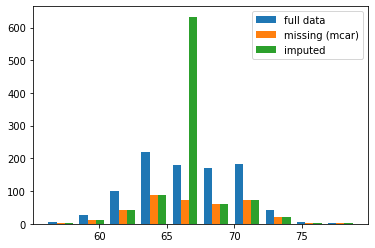

In [22]:
# counts of child heights
plt.hist([heights.child, heights_mcar.child.dropna(), heights_mcar_mfilled.child])
plt.legend([ 'full data', 'missing (mcar)', 'imputed']);

## Mean imputation and MAR data

* Mean imputation leads to biased estimates of mean across groups, when using MAR data.
* Since MAR is MCAR within each group, can do group-wise mean imputation.

In [23]:
heights_mar_cat = util.make_mar_on_cat(heights, 'child', 'gender', pct=0.50)

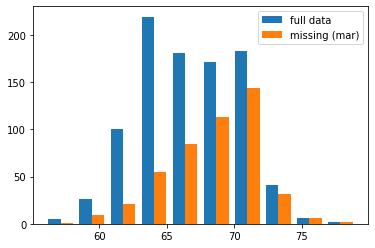

In [24]:
# The observed vs true distribution
plt.hist([heights.child, heights_mar_cat.child]);
plt.legend([ 'full data','missing (mar)']);

In [25]:
# naive mean imputation
heights_mar_cat_mfilled = heights_mar_cat.fillna(heights_mar_cat.child.mean())

In [26]:
print(
    'mean (original): %f' % heights.child.mean(),
    'mean (missing):  %f' % heights_mar_cat.child.mean(),
    'mean (mean imp): %f' % heights_mar_cat_mfilled.child.mean(),
    sep='\n'
)

mean (original): 66.745931
mean (missing):  68.319058
mean (mean imp): 68.319058


In [27]:
print(
    'std (original): %f' % heights.child.std(),
    'std (missing):  %f' % heights_mar_cat.child.std(),
    'std (mean imp): %f' % heights_mar_cat_mfilled.child.std(),
    sep='\n'
)

std (original): 3.579251
std (missing):  3.346108
std (mean imp): 2.364787


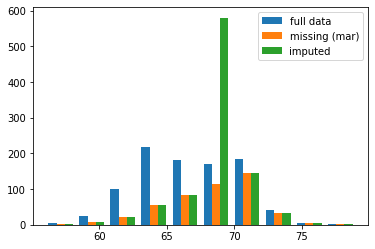

In [28]:
plt.hist([heights.child, heights_mar_cat.child, heights_mar_cat_mfilled.child]);
plt.legend([ 'full data','missing (mar)', 'imputed']);

In [29]:
# Biased mean by groups!
# How is this connected to simpson's paradox?
pd.concat([
    heights.groupby('gender').child.mean().rename('full'),
    heights_mar_cat.groupby('gender').child.mean().rename('missing (mar)'),
    heights_mar_cat_mfilled.groupby('gender').child.mean().rename('imputed')
], axis=1)

,full,missing (mar),imputed
gender,,,
female,64.103974,63.520513,67.492818
male,69.234096,69.281234,69.097200


### Discussion Question

* In MAR data, imputation by the mean gives a biased estimate of the mean of each group. 
* You can obtain an unbiased estimate of means across groups by imputing with the mean within each group.
* How would you code this up for `child` heights that are MAR dependent on `gender`?

Recall that unconditional mean imputation is given by `heights.child.fillna(heights.child.mean())`

## Conclusions: imputation with single values
* Imputing missing data in a column with the mean of the column:
    - faithfully reproduces the mean of the observed dataset,
    - reduces the variance,
    - biases relationships of the column with other columns.
    
* Similar with other statistics (median, mode).

### Discussion Question

* Consider the income reporting in the US Census. 
* Suppose we impute missing salaries with the mean overall income.
* Is there more bias in:
    - (low-paying) service jobs or 
    - (high-paying) executive jobs?
    
Hint: what does the distribution of incomes look like? Where is the mean/median?

## Imputing missing values using distributions
* We can *probalistically* impute missing data from a distribution.
    - Fill in missing data by drawing from the distribution of *non-missing* data.
* Recall: using `.sample`, we can draw from an (empirical) distribution.

### Imputing `heights_mcar` data by drawing from a distribution.

Steps:
* Sample values of child heights from the observed heights.
* Fill in missing child heights by using these draws from the observed heights.

In [30]:
num_null = heights_mcar.child.isnull().sum() # number of nulls
fill_values = heights_mcar.child.dropna().sample(num_null, replace=True)  # draw fill vals from distribution
fill_values.index = heights_mcar.loc[heights_mcar.child.isnull()].index  # align the index
heights_mcar_dfilled = heights_mcar.fillna({'child': fill_values.to_dict()})  # fill the vals

In [31]:
print(
    'mean (original):  %f' % heights.child.mean(),
    'mean (missing):   %f' % heights_mcar.child.mean(),
    'mean (distr imp): %f' % heights_mcar_dfilled.child.mean(),
    sep='\n'
)

mean (original):  66.745931
mean (missing):   66.801337
mean (distr imp): 66.864989


In [32]:
print(
    'std (original):  %f' % heights.child.std(),
    'std (missing):   %f' % heights_mcar.child.std(),
    'std (distr imp): %f' % heights_mcar_dfilled.child.std(),
    sep='\n'
)

std (original):  3.579251
std (missing):   3.636842
std (distr imp): 3.589673


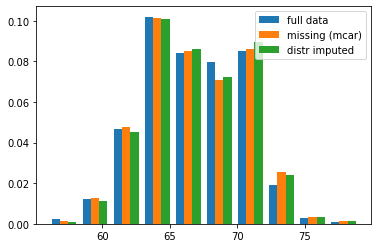

In [33]:
plt.hist([heights.child, heights_mcar.child, heights_mcar_dfilled.child], density=True);
plt.legend([ 'full data','missing (mcar)', 'distr imputed']);

## Observations
* We only drew missing values from observed values. What if a missing value was previously unobserved?
    - better to bin the data and draw from bins instead! 
    - use `np.histogram` to bin data.

* How does this generalize to categoricals?

## Observations

* We created an imputed dataset using randomness to preserve variance
* Our imputation could have been different, had we run it again
* *Multiple imputation*: generate multiple imputed datasets and aggregate each result!
    - Should remind you of bootstrap estimation.

## Multiple Imputation (Donald Rubin)

Multiple imputation is a 3 step process:

<div class="image-txt-container">

* **Imputation**: Impute a missing data multiple times (m times)
* **Analysis**: Analyze each complete dataset separetly (m sets)
* **Pooling**: Combine multiple analysis result. M estimates result in the final estimate.

<img src="imgs/mult_imp.png" width="50%">

</div>


### Multiple Imputation: steps

0. Start with observed and incomplete data. 
1. Create several **imputed** versions of the data by drawing from a distribution of plausible values.
    - The imputed datasets are identical for the observed data entries, 
    - they differ in the imputed values. 
    - The differences reflect our **uncertainty** about what value to impute.

2. Then we estimate the parameters of interest from **each** imputed dataset.
3. The last step is to pool the m parameter estimates into one estimate and to estimate its variance.

In [34]:
# heights_mcar is our incomplete data

def create_imputed(col):
    num_null = col.isnull().sum()
    fill_values = col.dropna().sample(num_null, replace=True)
    fill_values.index = col.loc[col.isnull()].index
    return col.fillna(fill_values.to_dict())


In [35]:
create_imputed(heights_mcar.child).head()

0    73.2
1    68.0
2    69.5
3    69.0
4    68.0
Name: child, dtype: float64

In [36]:
mult_imp = pd.concat([create_imputed(heights_mcar.child).rename(k) for k in range(100)], axis=1)
mult_imp.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,...,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2
1,71.2,72.0,63.0,62.0,69.0,64.0,70.0,72.0,60.0,66.0,...,66.0,64.0,64.5,66.5,63.0,62.0,67.5,72.0,66.5,70.0
2,69.2,62.0,62.0,64.0,70.0,65.5,70.0,63.0,57.0,66.5,...,70.5,65.0,66.0,63.0,70.5,65.0,60.0,63.0,66.0,66.0
3,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,...,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0,69.0
4,68.0,73.0,69.0,63.0,72.0,68.0,63.0,68.0,70.2,66.0,...,71.0,62.5,64.5,68.0,68.0,67.0,66.5,57.0,69.0,70.0


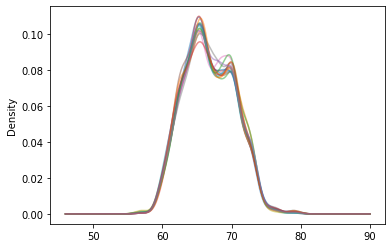

In [37]:
# plot 15 random imputations
mult_imp.sample(15, axis=1).plot(kind='kde', alpha=0.5, legend=False);

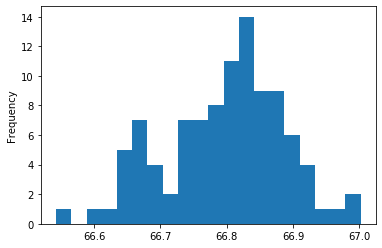

In [38]:
# sampling distribution of imputed means
mult_imp.mean().plot(kind='hist', bins=20);

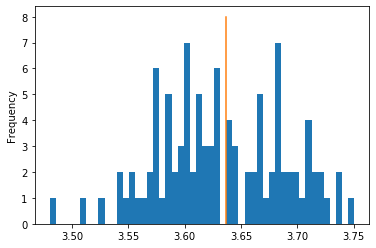

In [39]:
# doesn't decrease the standard deviations of imputed data
mult_imp.std().plot(kind='hist', bins=50)
std_incomplete = heights_mcar.child.std()
plt.plot([std_incomplete, std_incomplete], [0,8]);

### Discussion Question

* Suppose we *average* all the multiple imputed heights and impute data using that average.
* Does the variance of the imputed data:
    - Remain the same?
    - Decrease?

In [40]:
imputed = mult_imp.mean(axis=1)

In [41]:
print(
    'std (original):  %f' % heights.child.std(),
    'std (missing):   %f' % heights_mcar.child.std(),
    'std (distr imp): %f' % imputed.std(),
    sep='\n'
)

std (original):  3.579251
std (missing):   3.636842
std (distr imp): 2.315665


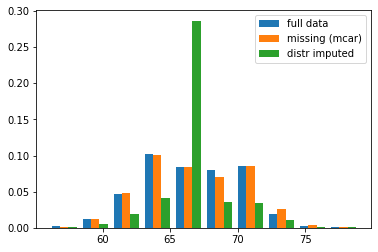

In [42]:
plt.hist([heights.child, heights_mcar.child, imputed], density=True);
plt.legend([ 'full data','missing (mcar)', 'distr imputed']);

## Missingness, conditional on multiple variables
* Use multiple imputation, as in previous example
* Imputate from a distribution for each variable
* Do an analysis per imputation; aggregate the analyses.

## Summary of Imputation Techniques

* Listwise deletion
* Mean imputation
* conditional mean / regression imputation
* Probabilistic imputation
* Multiple imputation

## Summary: listwise deletion

* Procedure: `.dropna()`
* If MCAR, doesn't change statistics of the data
* If MCAR and small, may have high variance

## Summary: (single value) mean imputation 

* Procedure: `.fillna(dataframe[col].mean())`
* If MCAR, gives unbiased estimate of mean; variance is too low.
* Analogue for categorical data: imputation with the mode.

## Summary: conditional mean imputation

* Procedure: for a column `c1`, conditional on a second column `c2`:
```
means = dataframe.groupby('c2').mean().to_dict()
imputed = dataframe['c1'].apply(lambda x: means[x] if pd.isnull(x) else x)
```
* If MAR, gives unbiased estimate of mean; variance is too low.
* Increases correlations between the columns.
* If dependent on *more than one* column: use linear regression to predict missing value.

## Summary: probabilistic imputation

* Procedure: draw from empirical distribution of observed data to fill missing values.
* If MCAR, gives unbiased estimate of mean and variance.
* Extending to MAR case: draw from *conditional empirical distributions*
    - if conditional on a single categorical column `c2`: 
    - apply MCAR procedure to the groups of `dataframe.groupby(c2)`

## Summary: multiple imputation

* Procedure:
    - Apply probabilistic imputation multiple times, resulting in $N$ imputed datasets.
    - Do analyses separately on the $N$ imputed datasets (e.g. compute correlation coefficient).
    - Plot the distribution of the results of these analyses!
* If a column is missing conditional on multiple columns, your "multiple imputations" should include probabilistic imputations for each!

## Summary of Imputation Techniques


|---|Unbiased|---|---|Standard Error|
|---|---|---|---|---|
|---|Mean|Regression weights|Correlation|---|
|Listwise deletion|MCAR|MCAR|MCAR|Large|
|Mean|MCAR|---|---|Small|
|Regressions|MAR|MAR|---|Small|
|Probabilistic|MAR|MAR|MAR|Large|
|Multiple|MAR|MAR|MAR|Good|
